
# Segmentación de Clientes con **K-Means** (CSV adjunto)

**Objetivo:** Identificar **segmentos latentes** de clientes a partir de su comportamiento de compras y uso del sitio (aprendizaje **no supervisado**).

**Dataset (columnas):**
1. `purchase_freq_month` — frecuencia de compras por mes (escala baja a media).  
2. `avg_basket_usd` — ticket/promedio por compra en USD (escala media a alta).  
3. `time_on_site_min` — tiempo de permanencia en el sitio (minutos).  
4. `discount_sensitivity` — sensibilidad a descuentos (0 a 1).  
5. `returns_rate` — tasa de devoluciones (0 a 0.8 aprox.).  

**Patrones esperados a detectar (ejemplos):**
- Alta frecuencia **pero** ticket bajo y **alta** sensibilidad a descuentos.  
- Frecuencia **baja** pero ticket **alto** y **baja** sensibilidad (compras esporádicas pero grandes).  
- Diferencias en **tiempo en sitio** y **tasa de devoluciones** (p. ej., exploran mucho y devuelven más vs. exploran poco y devuelven menos).



## 1) Setup, carga de datos y chequeos rápidos


In [ ]:

import sys, numpy as np, pandas as pd, matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from pathlib import Path
import joblib

print("Python:", sys.version.split()[0])

# Ruta del CSV
CSV_PATH = Path("/content/kmeans_3clusters_clean.csv")
assert CSV_PATH.exists(), f"No se encontró el archivo en {CSV_PATH}"

df = pd.read_csv(CSV_PATH)
print("Forma del dataset:", df.shape)
display(df.head())
print("\nValores nulos por columna:")
print(df.isna().sum())

# Aseguramos tipos numéricos
cols = ["purchase_freq_month","avg_basket_usd","time_on_site_min","discount_sensitivity","returns_rate"]
df = df[cols].apply(pd.to_numeric, errors="coerce")
df = df.dropna().reset_index(drop=True)
print("\nForma tras limpieza (dropna):", df.shape)

# Estadísticos rápidos
display(df.describe(percentiles=[0.25,0.5,0.75]).T)


Python: 3.12.12
Forma del dataset: (700, 5)


,purchase_freq_month,avg_basket_usd,time_on_site_min,discount_sensitivity,returns_rate
0,11.152508,181.300834,33.564036,1.000000,0.800000
1,12.053451,178.637272,35.432081,0.784974,0.000000
2,2.203006,450.185298,7.030757,0.898297,0.000000
3,4.233314,89.006342,10.834453,0.000000,0.800000
4,1.716799,449.773982,7.254548,0.000000,0.003279



Valores nulos por columna:
purchase_freq_month     0
avg_basket_usd          0
time_on_site_min        0
discount_sensitivity    0
returns_rate            0
dtype: int64

Forma tras limpieza (dropna): (700, 5)


,count,mean,std,min,25%,50%,75%,max
purchase_freq_month,700.0,5.875724,4.471079,0.100000,2.278418,4.134580,11.214919,14.603388
avg_basket_usd,700.0,248.173491,154.904372,86.994100,90.766945,180.223799,449.719033,452.973583
time_on_site_min,700.0,16.784799,12.914111,3.163206,6.603950,9.974407,34.341360,38.348156
discount_sensitivity,700.0,0.425083,0.431467,0.000000,0.000000,0.296475,1.000000,1.000000
returns_rate,700.0,0.337194,0.356623,0.000000,0.000000,0.165559,0.800000,0.800000



## 2) Exploración visual (distribuciones y relaciones clave)
> *Usamos `matplotlib` (sin estilos especiales) para mantener la compatibilidad.*


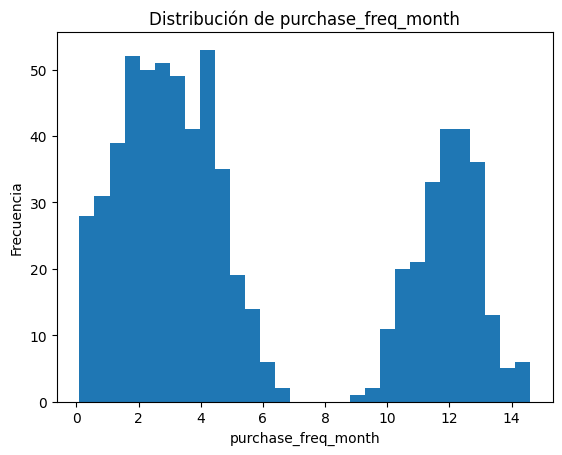

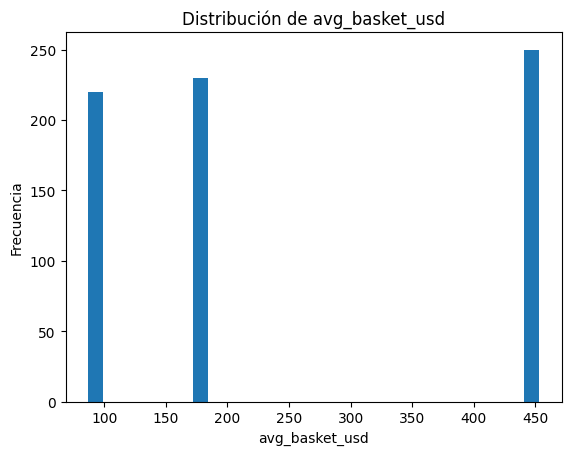

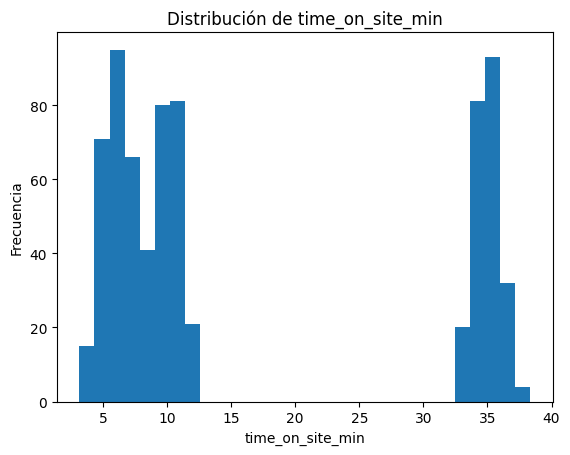

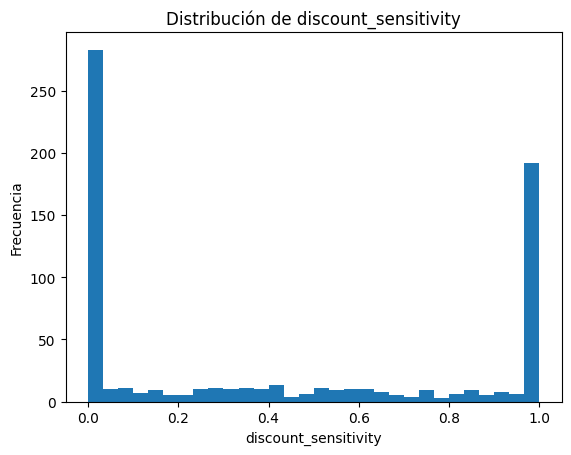

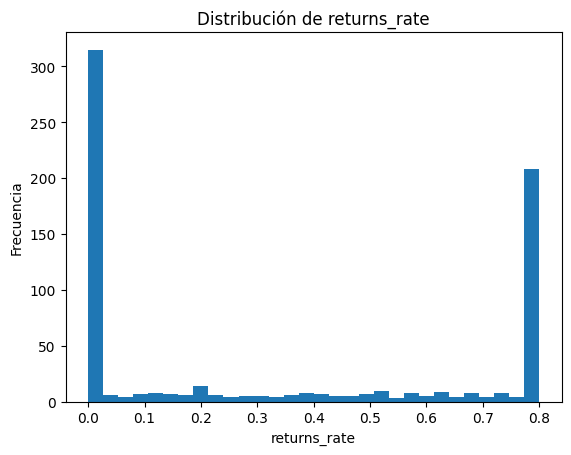

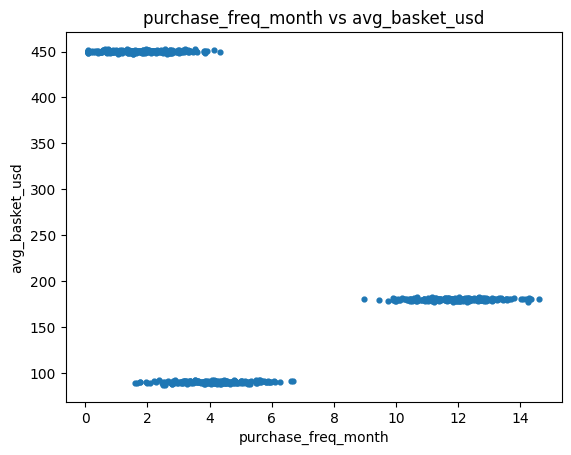

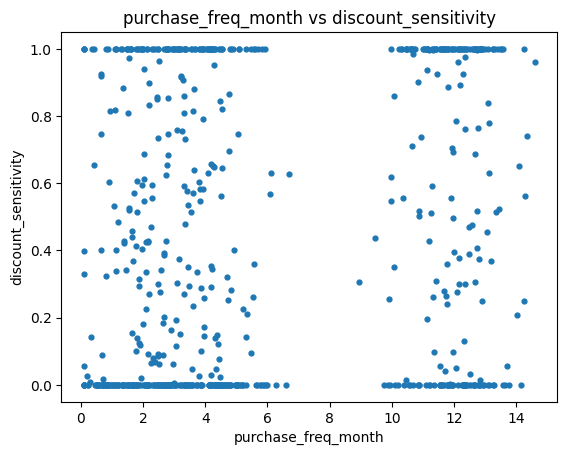

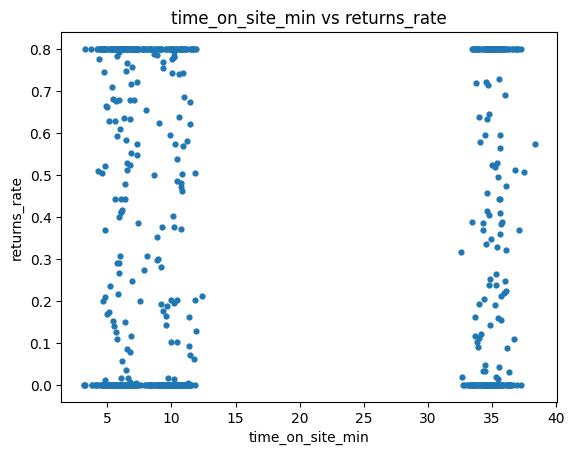

In [ ]:

# Histograma por variable
for c in df.columns:
    plt.figure()
    plt.hist(df[c], bins=30)
    plt.title(f"Distribución de {c}")
    plt.xlabel(c)
    plt.ylabel("Frecuencia")
    plt.show()

# Dispersión de algunas combinaciones útiles
pairs = [
    ("purchase_freq_month", "avg_basket_usd"),
    ("purchase_freq_month", "discount_sensitivity"),
    ("time_on_site_min", "returns_rate")
]
for xcol, ycol in pairs:
    plt.figure()
    plt.scatter(df[xcol], df[ycol], s=12)
    plt.title(f"{xcol} vs {ycol}")
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.show()



## 3) Preparación: **escalado** de variables

K-Means utiliza distancia euclídea y es **sensible a la escala**.  
- Si existen **outliers**, `RobustScaler` suele ser más estable.  
- Si las distribuciones son razonables, `StandardScaler` funciona bien.

Aquí probamos con `RobustScaler` (robusto a valores extremos). Podés cambiar a `StandardScaler()` si lo preferís.


In [ ]:

# Elegí el escalador: RobustScaler o StandardScaler
scaler = RobustScaler()
X = scaler.fit_transform(df.values)
print("Forma de X (escalada):", X.shape)


Forma de X (escalada): (700, 5)



## 4) Parámetros importantes de **KMeans** (scikit-learn)

- `n_clusters` (**int**): número de clusters (k) a buscar.  
- `init` (**'k-means++'** o `'random'` o array): inicialización de centroides. `'k-means++'` suele converger mejor.  
- `n_init` (**int**): repeticiones con diferentes semillas para elegir la mejor por **inercia** (SSE).  
- `max_iter` (**int**): máximo de iteraciones de Lloyd por ejecución.  
- `tol` (**float**): criterio de **convergencia**.  
- `random_state` (**int/None**): semilla para reproducibilidad.  
- `algorithm` (**'lloyd'**): variante del algoritmo (por defecto).  

**Atributos** tras `fit`:
- `cluster_centers_`: centroides en el **espacio escalado**.  
- `labels_`: cluster asignado a cada muestra.  
- `inertia_`: suma de cuadrados intra-cluster (SSE).  
- `n_iter_`: iteraciones realizadas.



## 5) ¿Cuántos clusters? **k = 2..6** con **codo** (inercia) y **silhouette**


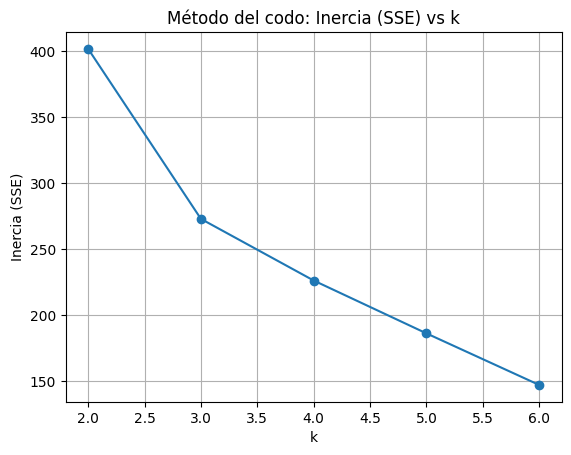

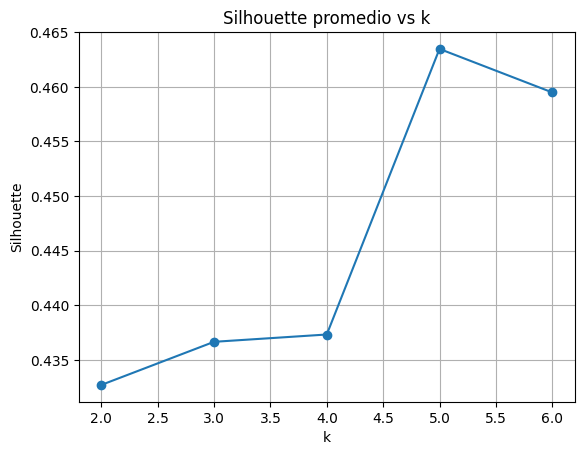

k recomendado por silhouette: 5
k=2: silhouette=0.4327
k=3: silhouette=0.4367
k=4: silhouette=0.4373
k=5: silhouette=0.4635
k=6: silhouette=0.4595


In [ ]:

ks = range(2, 7)
inertias, silhouettes = [], []

for k in ks:
    km = KMeans(
        n_clusters=k,
        init='k-means++', #Estrategia de inicialización que elige centroides “bien espaciados” para acelerar la convergencia y evitar malas soluciones por arranques aleatorios.
        #También podemos pasar 'random', una matriz con centros iniciales o un callable.
        n_init=20, #Número de reinicios independientes (con distintas semillas de centroides). El modelo corre 20 veces y se queda con la mejor inercia
        max_iter=500, #Tope de iteraciones de Lloyd por cada reinicio. Si antes ya cumple el criterio de convergencia, corta antes
        tol=1e-4, #Tolerancia relativa para declarar convergencia, medida sobre la norma de Frobenius del cambio en los centros entre dos iteraciones. Más chico ⇒ más estricto (posibles más iteraciones).
        random_state=42,
        algorithm='lloyd' #Variante clásica EM-style de k-means. Alternativa: 'elkan', que usa la desigualdad triangular para saltarse cálculos y puede ser más rápido cuando hay clusters bien separados, a costa de más memoria
                      #algorithm='elkan' si los datos son densos, con clusters definidos y queremos más velocidad
    )
    labels = km.fit_predict(X)
    inertias.append(km.inertia_) #La inertia en K-Means es la suma de las distancias euclidianas al cuadrado de cada muestra a su centroide más cercano. Cuanto menor, mejor (clusters más compactos).
    silhouettes.append(silhouette_score(X, labels))


# Gráfico: Codo
plt.figure()
plt.plot(list(ks), inertias, marker='o')
plt.title("Método del codo: Inercia (SSE) vs k")
plt.xlabel("k")
plt.ylabel("Inercia (SSE)")
plt.grid(True)
plt.show()

# Gráfico: Silhouette
plt.figure()
plt.plot(list(ks), silhouettes, marker='o')
plt.title("Silhouette promedio vs k")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.grid(True)
plt.show()

# Elección automática basada en silhouette


best_k = ks[int(np.argmax(silhouettes))]




print("k recomendado por silhouette:", best_k)
for k, s in zip(ks, silhouettes):
    print(f"k={k}: silhouette={s:.4f}")


**¿Qué es Silhouette?**

Mide, para cada punto, qué tan bien está dentro de su clúster comparado con el clúster vecino más cercano.

**¿Qué es Inertia?**

las distancias euclidianas al cuadrado de cada muestra a su centroide más cercano. Es decir, qué tan compactos son los clústeres.

Diferencias clave

**Qué miden:**

    Inertia: solo cohesión (compactación).

    Silhouette: cohesión + separación entre clústeres.

**Rango/Comparabilidad:**

    Inertia: no acotada, no comparable entre datasets.

    Silhouette: comparable entre distintos k en el mismo dataset.

**Elección de k:**

    Inertia: se usa el codo (visual, a veces ambiguo).

    Silhouette: se elige el k que maximiza el promedio (más objetivo).

**Riesgo:**

Inertia puede “premiar” micro-clústeres (sobresegmentación).

Silhouette penaliza clústeres pegados o mal separados.

Codo: busca el quiebre claro; si hay dos candidatos, elige el menor k (modelo más simple) salvo que el mayor k tenga una ganancia clara en silhouette.

Silhouette: elige el k con máximo promedio y clusters con barras consistentes en el gráfico de silhouette.

Si codo y silhouette no coinciden, priorizamos silhouette y valida con conocimiento del dominio (¿los clusters tienen sentido?).


## 6) Entrenamiento final con el **k** recomendado y análisis de centroides


In [ ]:

k_final = int(best_k)
kmeans = KMeans(
    n_clusters=k_final,
    init='k-means++',
    n_init=50,
    max_iter=800,
    tol=1e-4,
    random_state=42,
    algorithm='lloyd'
)
labels = kmeans.fit_predict(X)
centers_scaled = kmeans.cluster_centers_

# Convertimos centroides al espacio original para interpretar
centers_original = pd.DataFrame(
    data=scaler.inverse_transform(centers_scaled),
    columns=df.columns
)

df_clusters = df.copy()
df_clusters["cluster"] = labels

display(centers_original.round(3))
display(df_clusters.head())

print("Inercia (SSE):", kmeans.inertia_, "| Iteraciones:", kmeans.n_iter_)
unique, counts = np.unique(labels, return_counts=True)
print("Tamaño de clusters:", dict(zip(unique, counts)))

# Guardamos artefactos para reuso/producción
out_dir = Path("/mnt/data")
out_dir.mkdir(exist_ok=True, parents=True)
df_clusters.to_csv(out_dir / "clientes_segmentados.csv", index=False)
centers_original.to_csv(out_dir / "centroides_kmeans.csv", index=False)
joblib.dump(kmeans, out_dir / "kmeans_model.joblib")
joblib.dump(scaler, out_dir / "scaler.joblib")
print("Archivos guardados en /mnt/data: clientes_segmentados.csv, centroides_kmeans.csv, kmeans_model.joblib, scaler.joblib")


,purchase_freq_month,avg_basket_usd,time_on_site_min,discount_sensitivity,returns_rate
0,11.961,179.999,35.022,0.542,0.332
1,1.886,450.208,5.887,0.358,0.041
2,4.225,89.876,10.053,0.347,0.732
3,1.805,450.034,6.067,0.358,0.732
4,4.010,90.008,9.974,0.399,0.031


,purchase_freq_month,avg_basket_usd,time_on_site_min,discount_sensitivity,returns_rate,cluster
0,11.152508,181.300834,33.564036,1.000000,0.800000,0
1,12.053451,178.637272,35.432081,0.784974,0.000000,0
2,2.203006,450.185298,7.030757,0.898297,0.000000,1
3,4.233314,89.006342,10.834453,0.000000,0.800000,2
4,1.716799,449.773982,7.254548,0.000000,0.003279,1


Inercia (SSE): 186.23337102782617 | Iteraciones: 4
Tamaño de clusters: {np.int32(0): np.int64(230), np.int32(1): np.int64(129), np.int32(2): np.int64(84), np.int32(3): np.int64(121), np.int32(4): np.int64(136)}
Archivos guardados en /mnt/data: clientes_segmentados.csv, centroides_kmeans.csv, kmeans_model.joblib, scaler.joblib



## 7) Visualización 2D con **PCA** y fronteras aproximadas


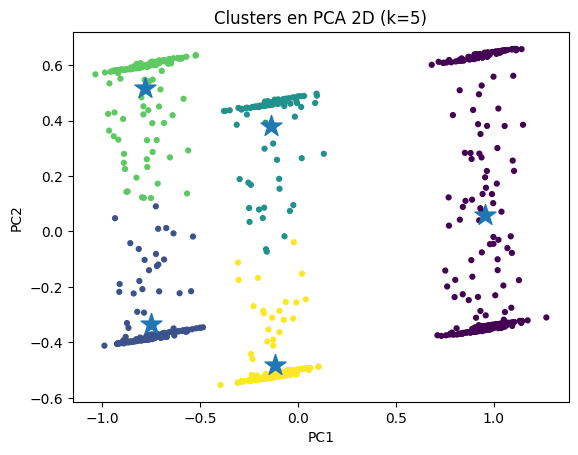

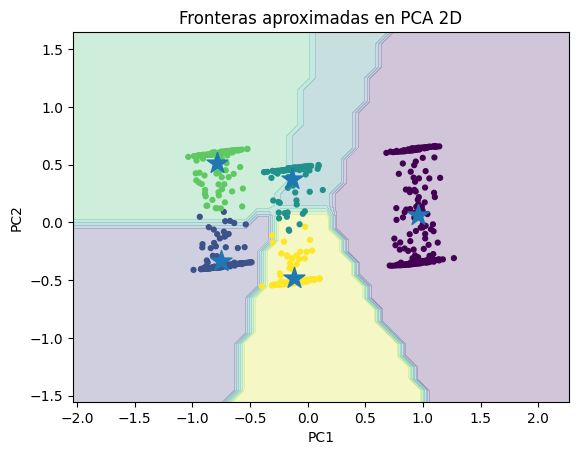

In [ ]:
# Reducimos a 2D para graficar
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X)
centers_2d = pca.transform(centers_scaled)

# Puntos por cluster
plt.figure()
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=12)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], marker='*', s=250)
plt.title(f"Clusters en PCA 2D (k={k_final})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Fronteras aproximadas sobre la proyección 2D (estimativa)
h = 0.1
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_2d = np.c_[xx.ravel(), yy.ravel()]

# Aproximamos predicción en la proyección: transformamos grid inversamente a PCA
# NOTA: Esta aproximación usa un truco: llevamos grid_2d a espacio escalado asumiendo componente nula fuera de las 2 PCs
# para poder usar el modelo, lo cual es sólo una visualización aproximada.
# The inverse transform should be applied to the 2D grid directly
grid_scaled = pca.inverse_transform(grid_2d)  # Corrected: inverse transform applied to grid_2d
Z = kmeans.predict(grid_scaled).reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z, alpha=0.25)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=12)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], marker='*', s=250)
plt.title("Fronteras aproximadas en PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


## 8) Perfiles de clusters interpretables (auto-generados)

Compararemos cada centroide contra cuartiles del dataset original para etiquetar rasgos **Altos/Medios/Bajos** por variable y generar descripciones.


In [ ]:

q = df.quantile([0.25, 0.5, 0.75])
q1, q2, q3 = q.loc[0.25], q.loc[0.5], q.loc[0.75]

def tag_level(val, col):
    if val <= q1[col]: return "bajo"
    if val >= q3[col]: return "alto"
    return "medio"

profiles = []
for i, row in centers_original.iterrows():
    desc = []
    for col in df.columns:
        desc.append(f"{col}: {tag_level(row[col], col)} ({row[col]:.2f})")
    profiles.append((i, "; ".join(desc)))

for cid, txt in profiles:
    print(f"Cluster {cid}: {txt}")


Cluster 0: purchase_freq_month: alto (11.96); avg_basket_usd: medio (180.00); time_on_site_min: alto (35.02); discount_sensitivity: medio (0.54); returns_rate: medio (0.33)
Cluster 1: purchase_freq_month: bajo (1.89); avg_basket_usd: alto (450.21); time_on_site_min: bajo (5.89); discount_sensitivity: medio (0.36); returns_rate: medio (0.04)
Cluster 2: purchase_freq_month: medio (4.23); avg_basket_usd: bajo (89.88); time_on_site_min: medio (10.05); discount_sensitivity: medio (0.35); returns_rate: medio (0.73)
Cluster 3: purchase_freq_month: bajo (1.80); avg_basket_usd: alto (450.03); time_on_site_min: bajo (6.07); discount_sensitivity: medio (0.36); returns_rate: medio (0.73)
Cluster 4: purchase_freq_month: medio (4.01); avg_basket_usd: bajo (90.01); time_on_site_min: medio (9.97); discount_sensitivity: medio (0.40); returns_rate: medio (0.03)



## 9) Sugerencia de **personas**/acciones (reglas simples basadas en centroides)

Reglas heurísticas para conectar con los **patrones esperados**:
- **Alta frecuencia + ticket bajo + alta sensibilidad a descuentos** → foco en **promos** y **bundles**.  
- **Baja frecuencia + ticket alto + baja sensibilidad** → foco en **upselling premium** y **early access**.  
- **Mucho tiempo en sitio + alta tasa de devoluciones** → **mejorar descripciones**, talles, políticas de devolución.  
- **Poco tiempo en sitio + devoluciones bajas** → simplificar **checkout** y **recomendaciones** rápidas.



## 10) Nuevas **predicciones** con el modelo

Ejemplos sintéticos para ver a qué cluster pertenecerían:


In [ ]:

# Nuevos clientes hipotéticos (en escala original)
new_customers = pd.DataFrame({
    "purchase_freq_month":[8, 1, 3, 6, 2],
    "avg_basket_usd":[25, 320, 180, 40, 500],
    "time_on_site_min":[20, 6, 45, 30, 10],
    "discount_sensitivity":[0.85, 0.1, 0.4, 0.7, 0.05],
    "returns_rate":[0.10, 0.02, 0.35, 0.15, 0.01]
})
print("Nuevos clientes (original):")
display(new_customers)

# Transformamos y predecimos
X_new = scaler.transform(new_customers.values)
preds = kmeans.predict(X_new)
dists = kmeans.transform(X_new)

out = new_customers.copy()
out["cluster_pred"] = preds
display(out)

for i, (lab, dist) in enumerate(zip(preds, dists)):
    print(f"Cliente {i} -> cluster {lab} | distancias a centroides: {np.round(dist,3)}")


Nuevos clientes (original):


,purchase_freq_month,avg_basket_usd,time_on_site_min,discount_sensitivity,returns_rate
0,8,25,20,0.85,0.10
1,1,320,6,0.10,0.02
2,3,180,45,0.40,0.35
3,6,40,30,0.70,0.15
4,2,500,10,0.05,0.01


,purchase_freq_month,avg_basket_usd,time_on_site_min,discount_sensitivity,returns_rate,cluster_pred
0,8,25,20,0.85,0.10,4
1,1,320,6,0.10,0.02,1
2,3,180,45,0.40,0.35,0
3,6,40,30,0.70,0.15,4
4,2,500,10,0.05,0.01,1


Cliente 0 -> cluster 4 | distancias a centroides: [0.925 1.542 1.103 1.733 0.757]
Cliente 1 -> cluster 1 | distancias a centroides: [1.76  0.457 1.19  0.999 0.796]
Cliente 2 -> cluster 0 | distancias a centroides: [1.075 1.65  1.378 1.669 1.352]
Cliente 3 -> cluster 4 | distancias a centroides: [0.841 1.552 1.109 1.708 0.838]
Cliente 4 -> cluster 1 | distancias a centroides: [1.804 0.371 1.507 0.975 1.216]


**Cómo validar un modelo de K-Means**

Como no hay etiquetas, se utilizan:

**Validación interna**

    Usar métricas como Silhouette, CH, DB Index para medir compactación y separación.

    Se hace sobre el mismo dataset.

**Validación relativa**

    Comparar varias configuraciones de K (número de clusters) y elegir la que optimiza la métrica.

**Validación externa (si hay etiquetas conocidas, aunque no se usen en el entrenamiento)**

    Comparar con métricas de clasificación: ARI (Adjusted Rand Index), NMI (Normalized Mutual Information), Fowlkes-Mallows.

    Ejemplo: clustering de clientes y después comparar con categorías reales (premium, estándar).

**Diferencias con métricas y validación en aprendizaje supervisado**

| Aspecto                 | Aprendizaje Supervisado                                       | K-Means (No Supervisado)                                              |
| ----------------------- | ------------------------------------------------------------- | --------------------------------------------------------------------- |
| **Datos de referencia** | Se tienen etiquetas reales (y = “verdad”)                     | No se tienen etiquetas                                                |
| **Métricas comunes**    | Accuracy, Precision, Recall, F1, ROC-AUC, MSE, RMSE, R², etc. | Inertia, Silhouette, CH, DB                                           |
| **Validación**          | Train/Test split, Cross-validation (k-fold)                   | Validación interna, relativa, y externa (si hay etiquetas auxiliares) |
| **Objetivo**            | Minimizar error de predicción respecto a valores reales       | Maximizar cohesión intra-cluster y separación inter-cluster           |
